# 1. 
## Identificación de barcos usando imágenes satelitales 
Actualmente se cuenta con muchas imágenes satelitales de alta resolución, pero con poca frecuencia de actualización, compañias como Planet han comenzado ha utilizar pequeños satélites que permiten tomar fotografías diarias de California, sin embargo planea expandir este proceso hasta cubrir todo Estados Unidos.  

El proyecto consiste en utilizar una CNN, especificamente una simplificación de LeNet-5 para identificar barcos, los datos fueron obtenidos de la base de datos de [planet](https://www.planet.com/) y publicados en [kaggle](https://www.kaggle.com/rhammell/ships-in-satellite-imagery) por Bob Hammell bajo la licencia 
[CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/), que permite su uso y transformación.
## Datos  
* Los inputs consisten de 4000 imagenes RGB de 80x80 pixeles, recolectadas de la Bahía de San Francisco y San Pedro, California, los outputs son 1 (barco en la imágen) y 0 (no hay barco).

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
plt.style.use('seaborn')

import torch 
from torchvision import transforms, datasets

from sklearn.model_selection import train_test_split
import json

In [2]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [3]:
f = open('dataset/shipsnet.json')
dataset = json.load(f)
f.close()

In [4]:
X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
print(X.shape)
print(y.shape)

(4000, 19200)
(4000,)


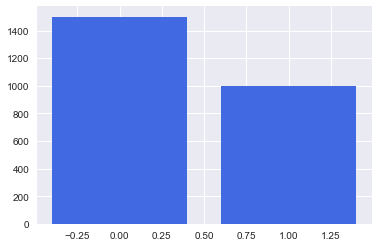

In [5]:
X = X[:2500]
y = y[:2500]

width = 80
height = 80
X = X.reshape([-1, 3, width, height])

unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, color='royalblue')
plt.show()

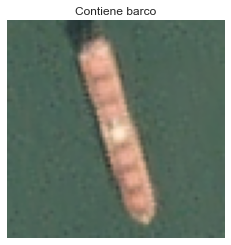

In [6]:
dic={0:'No contiene barco',1:'Contiene barco'}
sample = 13
plt.imshow(X[sample].transpose([1,2,0]))
plt.title(dic[y[sample]])
plt.axis('off')
plt.show()

# 3.
## Separación de datos

In [7]:
X = X/255.0
y = to_categorical(y, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.Tensor([x for x in X_train])
y_train = torch.Tensor([x for x in y_train])

X_test = torch.Tensor([x for x in X_test])
y_test = torch.Tensor([x for x in y_test])

# 4.   
## Definición, entrenamiento y evaluación de red neuronal

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(4624, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 4624)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.softmax(x,dim=1)
        return x      

net = Net()
print(net) 

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4624, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [10]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.MSELoss()

In [11]:
epochs = 50
batch_size = 30
for epoch in range(epochs):
    for i in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

100%|██████████| 67/67 [00:04<00:00, 15.56it/s]tensor(0.0199, grad_fn=<MseLossBackward>)



In [12]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        real_class = torch.argmax(y_test[i])
        net_out = net(X_test[i].view(-1,3,80,80))[0]
        predicted_class = torch.argmax(net_out)
        if (predicted_class == real_class):
            correct += 1
        total += 1
print('Accuracy:', round(correct/total, 3))


100%|██████████| 500/500 [00:01<00:00, 384.92it/s]Accuracy: 0.952



# 5.
## Inferencia.
Para la inferencia usaremos esceneas obtenidas de la API de Planet, el script utilizado para análisar la escena se baso en el publicado por el usuario Vitali Burachonok en [kaggle](https://www.kaggle.com/byrachonok/keras-for-search-ships-in-satellite-image), este consiste en:

* Cargamos la escena, la cuál es una imágen.    
* $cutting(x,y)$: nos regresa el cuadrado con vértice izquierdo inferior en (x,y), de 80 pixeles por lado.  
* $not\_near(x,y,coordinates)$: regresa falso si ya hay un cuadrado registrado previamente que contenga un barco, que se traslapa con el actual(de vértice izquierdo inferior (x,y)).
* Iteramos en los pixeles de la imagen con tamaño de paso $step=10$, en cada iteración recortamos un cuadrado usando la función $cutting$, en caso de encontrar un barco cargamos la imágen y guardamos las coordenadas.
* $show\_ship(x,y,thickness=5)$: modifica la imágen haciendo un cuadrado blanco vació con esquina izquierda inferior en $(x,y)$, de longitud $80$ pixeles y ancho de lados $thickness=5$.

In [13]:
picture_tensor = mpimg.imread('dataset/scenes/sf_1.png')
picture_tensor *= 255
picture_tensor = picture_tensor.astype('uint8')
height,width = picture_tensor.shape[:2]
picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor.shape

(3, 1570, 814)

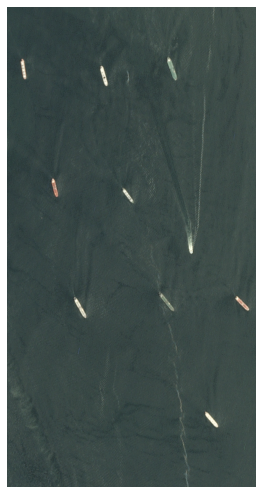

In [14]:
plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(picture_tensor.transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [15]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study/255
    return area_study

In [16]:
def not_near(x, y, coordinates):
    result = True
    s = 80
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

tensor([[0.0701, 0.9299]], grad_fn=<SoftmaxBackward>)


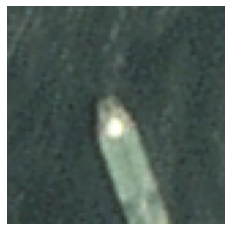

tensor([[0.0355, 0.9645]], grad_fn=<SoftmaxBackward>)


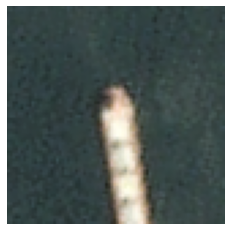

tensor([[0.0830, 0.9170]], grad_fn=<SoftmaxBackward>)


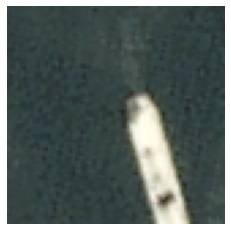

tensor([[0.0021, 0.9979]], grad_fn=<SoftmaxBackward>)


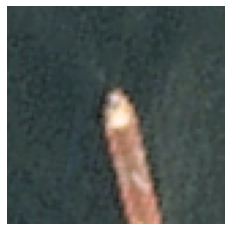

tensor([[0.0863, 0.9137]], grad_fn=<SoftmaxBackward>)


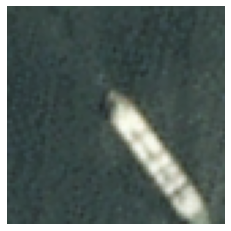

tensor([[0.0178, 0.9822]], grad_fn=<SoftmaxBackward>)


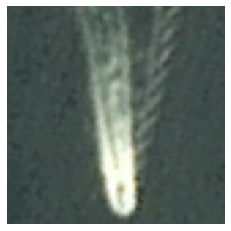

tensor([[0.0840, 0.9160]], grad_fn=<SoftmaxBackward>)


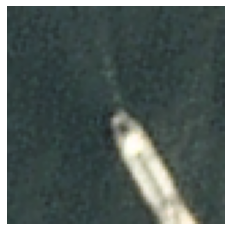

tensor([[0.0653, 0.9347]], grad_fn=<SoftmaxBackward>)


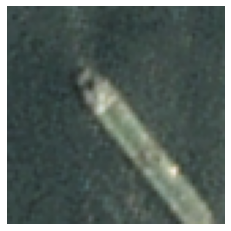

tensor([[0.0572, 0.9428]], grad_fn=<SoftmaxBackward>)


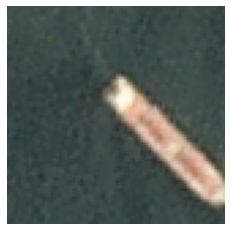

tensor([[0.0161, 0.9839]], grad_fn=<SoftmaxBackward>)


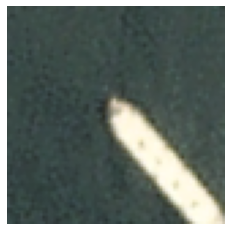

In [17]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step)):
        area = cutting(x*step, y*step)
        result = net(torch.Tensor(area))
        if result[0][1] > 0.9 and not_near(x*step,y*step, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0].transpose(1, 2, 0))
            plt.axis('off')
            plt.show()

In [18]:
def show_ship(x, y, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

In [19]:
for e in coordinates:
    show_ship(e[0][0], e[0][1])

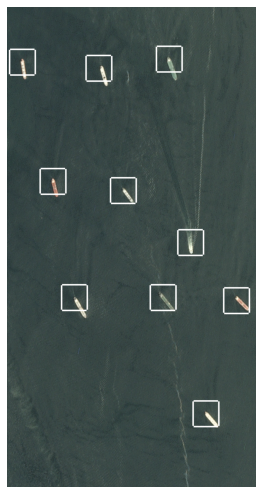

In [20]:
plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(picture_tensor.transpose(1, 2, 0))
plt.axis('off')
plt.show()

# 6.
## Comentario
Se obtuvo una precisión del 95% usando los datos de prueba, esto se debe a que se utilizó una red convolucional y dropout para evitar overfitting, se uso una simplificación de la arquitectura LeNet-5, este tipo de redes son eficientes en problemas de clasificación de imágenes. Algo que se puede hacer para mejorar el modelo es implementar data argumentation ya que solo se cuenta con 2500 imágenes en total.